# Assignment-1
## Team: Aditya Ahuja (2020275), Deeptanshu Barman Chowdhuri (2020293)

##  Imports & Dataset

In [74]:
import torch
import requests
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import random_split
import lightning as L
import matplotlib.pyplot as plt
import torchmetrics

In [2]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# device = "cpu"


In [ ]:
Noise_0_data = requests.get(
    "http://AdityaAhuja01.pythonanywhere.com/data/df_syn_train_0_0_.csv"
)
Noise_Low_data = requests.get(
    "http://AdityaAhuja01.pythonanywhere.com/data/df_synA_train_shuffled.csv"
)
Noise_High_data = requests.get(
    "http://AdityaAhuja01.pythonanywhere.com/data/df_synA_test_hard_shuffled_sample.csv"
)

if Noise_0_data.status_code == 200 and Noise_Low_data.status_code == 200 and Noise_High_data.status_code == 200:
    datafolder = "Data/Assignment1"

    if not os.path.exists(datafolder):
        os.makedirs(datafolder)

    with open(os.path.join(datafolder, "data_0_noise"), "wb") as f:
        f.write(Noise_0_data.text.encode("utf-8"))

    with open(os.path.join(datafolder, "data_Low_noise"), "wb") as f:
        f.write(Noise_Low_data.text.encode("utf-8"))

    with open(os.path.join(datafolder, "data_High_noise"), "wb") as f:
        f.write(Noise_High_data.text.encode("utf-8"))
else:
    print("Error in fetching data")

In [4]:
Noise_0_dataframe = pd.read_csv("../Data/Assignment1/data_0_noise")
Noise_Low_dataframe = pd.read_csv("../Data/Assignment1/data_Low_noise")
Noise_High_dataframe = pd.read_csv("../Data/Assignment1/data_High_noise")

In [6]:
class_index = list(Noise_0_dataframe["era"].unique())
class_index_noise = list(Noise_Low_dataframe["era"].unique())


def encode(value, class_index = class_index):
    return class_index.index(value)

def encode_noise(value, class_index = class_index_noise):
    return class_index.index(value)


Noise_0_dataframe["era"] = Noise_0_dataframe["era"].apply(encode)
Noise_Low_dataframe["era"] = Noise_Low_dataframe["era"].apply(encode_noise)
Noise_High_dataframe["era"] = Noise_High_dataframe["era"].apply(encode_noise)

## Setting up Dataset & Dataloaders

In [7]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, noise, transform=None, target_transform=None, target=None, drop=None):
        self.dataframe = dataframe
        if drop != None:
            self.X = dataframe.drop(drop, axis=1).values
        else:
            self.X = dataframe.values
        self.y = dataframe[target].values
        self.transform = transform
        self.target_transform = target_transform
        self.noise = noise

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item, label = self.X[idx], self.y[idx]
        return item, label

    def get_noise(self):
        return self.noise

In [55]:
#Setting up datasets
Noise_0_dataset = CustomDataset(Noise_0_dataframe, "0",drop = ["row_num","day","era","target_10_val","target_5_val"], target = "era")
Noise_Low_dataset = CustomDataset(Noise_Low_dataframe, "Low", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "era")
Noise_High_dataset = CustomDataset(Noise_High_dataframe, "High", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "era")
Noise_0_train, Noise_0_test = random_split(Noise_0_dataset, [int(0.9 * len(Noise_0_dataset)), len(Noise_0_dataset) - int(0.9 * len(Noise_0_dataset))])
Noise_Low_train, Noise_Low_test = random_split(Noise_Low_dataset, [int(0.8 * len(Noise_Low_dataset)), len(Noise_Low_dataset) - int(0.8 * len(Noise_Low_dataset))])
Noise_High_train, Noise_High_test = random_split(Noise_High_dataset, [int(0.8 * len(Noise_High_dataset)), len(Noise_High_dataset) - int(0.8 * len(Noise_High_dataset))])

In [56]:
#Setting up dataloaders
Noise_0_train_loader = DataLoader(Noise_0_train, batch_size=32, shuffle=True)
Noise_0_test_loader = DataLoader(Noise_0_test, batch_size=32, shuffle=True)
Noise_Low_train_loader = DataLoader(Noise_Low_train, batch_size=128, shuffle=True)
Noise_Low_test_loader = DataLoader(Noise_Low_test, batch_size=128, shuffle=True)
Noise_High_train_loader = DataLoader(Noise_High_train, batch_size=128, shuffle=True)
Noise_High_test_loader = DataLoader(Noise_High_test, batch_size=128, shuffle=True)

## Model

In [68]:
class MyMLP(torch.nn.Module):
    def __init__ (self, layers,activation = torch.nn.ReLU(), dropout = 0.5):
        super().__init__()
        linear = [torch.nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]
        self.layers = []
        for i in range(len(linear)):
            if (i == 0 or i == len(linear)-1):
                self.layers.append(linear[i])
                self.layers.append(linear[i])
            else:
                self.layers.append(linear[i])
                self.layers.append(activation)
                if (dropout!=0): self.layers.append(torch.nn.Dropout(dropout))
        self.layers = torch.nn.Sequential(*self.layers)
        
        self.softmax = torch.nn.LogSoftmax(dim = 1)
        
    def forward(self, X):          
        X = self.layers(X)
        X = self.softmax(X)
        return X  
    

In [106]:
class EnsembleClassifier():
  def __init__(self, Dataset, num_classifiers,sample_percentage = 0.9):
    self.train_set,self.validation_set = random_split(Dataset, [int(0.9 * len(Dataset)), len(Dataset) - int(0.9 * len(Dataset))])
    self.sample_percentage = sample_percentage
    self.num_classifiers = num_classifiers
    self.models = torch.nn.ModuleList()

    for clf in range(num_classifiers):
      self.models.append(MyMLP(layers = [24,64,32,12], dropout=0.2).to(device))

  def train(self,criterion,batchsize,num_epochs):
      validation_loader = DataLoader(self.validation_set, batch_size = batchsize, shuffle = True)
      train_loss = {}
      train_accuracy = {}
      val_loss = []
      val_accuracy = []
      num_samples = len(self.train_set)
      indices = list(range(num_samples))
      bootstrap_dataloaders = []
      accuracy = torchmetrics.Accuracy(task = "multiclass",num_classes = 12).to(device)

      for c in range(self.num_classifiers):
          sampled_indices = torch.randperm(num_samples)[:int(num_samples * self.sample_percentage)]
          sampler = SubsetRandomSampler(sampled_indices)
          sampled_dataloader = DataLoader(self.train_set, batch_size = batchsize, sampler=sampler)
          bootstrap_dataloaders.append(sampled_dataloader)

      for epoch in range(num_epochs):
        print("Starting Epoch-",epoch)
        for model_num in range(len(self.models)):
          model_loss = 0
          model_accuracy = 0
          optimizer = torch.optim.Adam(self.models[model_num].parameters(), lr=0.0001, weight_decay=0.001)
          self.models[model_num].train()
          for inputs, labels in bootstrap_dataloaders[model_num]:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
            optimizer.zero_grad()
            outputs = self.models[model_num](inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            model_loss += loss.item()
            model_accuracy += accuracy(outputs, labels)
          print(f"Epoch-{epoch} model-{model_num} Loss: {model_loss/len(bootstrap_dataloaders[model_num])} Accuracy: {model_accuracy/len(bootstrap_dataloaders[model_num])}")
            
          
      #Validation
      for model_num in range(len(self.models)):
        self.models[model_num].eval()
      
      with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_accuracy = 0
        for inputs, labels in validation_loader:
          model_preds = 0
          inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
          
          for model in self.models:
            outputs = model(inputs)
            model_preds += outputs
            
        model_preds /= self.num_classifiers
        val_epoch_loss += criterion(model_preds, labels)
        val_epoch_accuracy += accuracy(model_preds, labels)
        val_loss.append(val_epoch_loss.item())
        val_accuracy.append(val_epoch_accuracy.item())
        plt.plot(val_loss)
        plt.plot(val_accuracy)
        plt.show()          
              
              
  def forward(self, x):
    ensemble_predictions = torch.zeros(x.size(0), 12, device=device)
    for model_num in range(len(self.models)):
      self.models[model_num].eval()
      outputs = self.models[model_num](x)
      ensemble_predictions += outputs
    ensemble_predictions /= self.num_classifiers
    return ensemble_predictions


In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10,verbose=True):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()


MyMLP(
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=12, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/200], Train Loss: 2.1723, Train Acc: 0.2531, Val Loss: 1.6745, Val Acc: 0.4167
Epoch [2/200], Train Loss: 1.3617, Train Acc: 0.5328, Val Loss: 1.0936, Val Acc: 0.6282
Epoch [3/200], Train Loss: 1.0453, Train Acc: 0.6312, Val Loss: 0.8911, Val Acc: 0.7128
Epoch [4/200], Train Loss: 0.8810, Train Acc: 0.7084, Val Loss: 0.7412, Val Acc: 0.7615
Epoch [5/200], Train Loss: 0.7770, Train Acc: 0.7339, Val Loss: 0.6851, Val Acc: 0.7538
Epoch [6/200], Train Loss: 0.7125, Train Acc: 0.7561, Val Loss: 0.6402, Val Acc: 0.7744
Epoch [7/200], Train Loss: 0.6659, Train Acc: 0.7665, Val Loss: 0.5971, Val Acc: 0.8038
Epoch [8/200], Train Loss: 0.6323, Train Acc: 0.7813, Val Loss: 0.5463, Val Acc: 0.8218
Epoch [9/200], Train Loss: 0.605

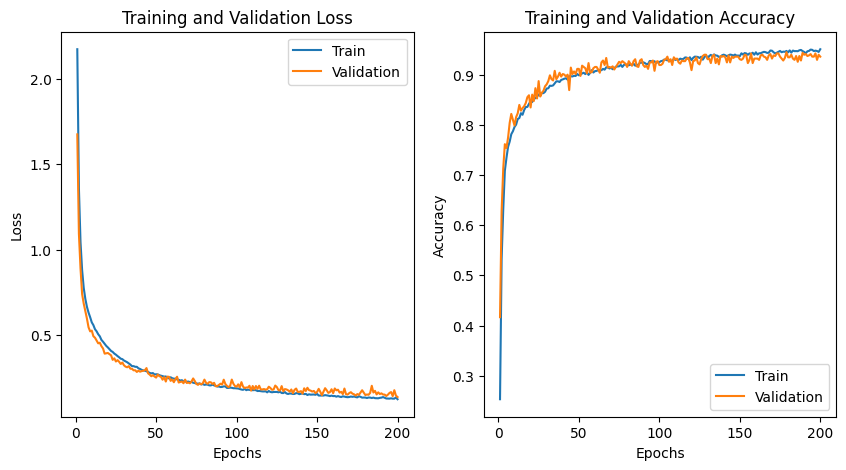

In [70]:
Model = MyMLP(layers = [24,64,32,12], dropout=0).to(device)
Model = Model.to(device)
print(Model)
optimizer = optim.Adam(Model.parameters(), lr=0.001)
train_model(Model,torch.nn.NLLLoss(), optimizer,Noise_0_train_loader, Noise_0_test_loader,num_epochs=200)

MyMLP(
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/20], Train Loss: 1.2072, Train Acc: 0.5385, Val Loss: 0.9921, Val Acc: 0.6264
Epoch [2/20], Train Loss: 1.0853, Train Acc: 0.5819, Val Loss: 0.9194, Val Acc: 0.6495
Epoch [3/20], Train Loss: 1.0640, Train Acc: 0.5887, Val Loss: 0.9145, Val Acc: 0.6660
Epoch [4/20], Train Loss: 1.0525, Train Acc: 0.5942, Val Loss: 0.8988, Val Acc: 0.6604
Epoch [5/20], Train Loss: 1.0408, Train Acc: 0.5976, Val Loss: 0.9117, Val Acc: 0.6538
Epoch [6/20], Train Loss: 1.0333, Train Acc: 0.6017, Val Loss: 0.8883, Val Acc: 0.6563
Epoch [7/20], Train Loss: 1.0300, Train Acc: 0.6027, Val Loss: 0.8862, Val Acc: 0.6707
Epoch [8/20], Train Loss: 1.0259, Train Acc: 0.6043, Val Loss: 0.8803, Val Acc: 0.6646
E

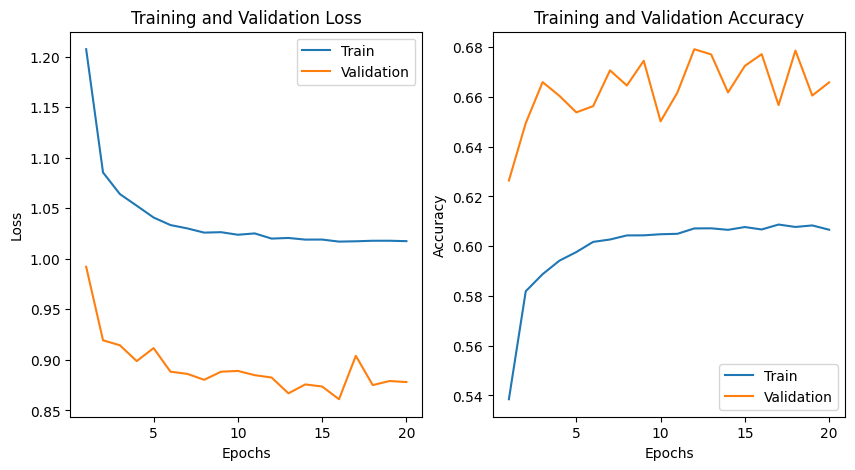

In [71]:
Model = MyMLP(layers = [24,64,32,12], dropout=0.2).to(device)
print(Model)
optimizer = optim.Adam(Model.parameters(), lr=0.01, weight_decay=0.001)
train_model(Model,torch.nn.CrossEntropyLoss(), optimizer,Noise_Low_train_loader, Noise_Low_test_loader,num_epochs=20)

MyMLP(
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/20], Train Loss: 1.7407, Train Acc: 0.3606, Val Loss: 1.5495, Val Acc: 0.4359
Epoch [2/20], Train Loss: 1.6534, Train Acc: 0.3903, Val Loss: 1.5670, Val Acc: 0.4265
Epoch [3/20], Train Loss: 1.6444, Train Acc: 0.3942, Val Loss: 1.5349, Val Acc: 0.4411
Epoch [4/20], Train Loss: 1.6359, Train Acc: 0.3972, Val Loss: 1.5373, Val Acc: 0.4336
Epoch [5/20], Train Loss: 1.6308, Train Acc: 0.4007, Val Loss: 1.5322, Val Acc: 0.4389
Epoch [6/20], Train Loss: 1.6265, Train Acc: 0.4008, Val Loss: 1.5298, Val Acc: 0.4307
Epoch [7/20], Train Loss: 1.6229, Train Acc: 0.4030, Val Loss: 1.5256, Val Acc: 0.4398
Epoch [8/20], Train Loss: 1.6209, Train Acc: 0.4020, Val Loss: 1.5392, Val Acc: 0.4333
E

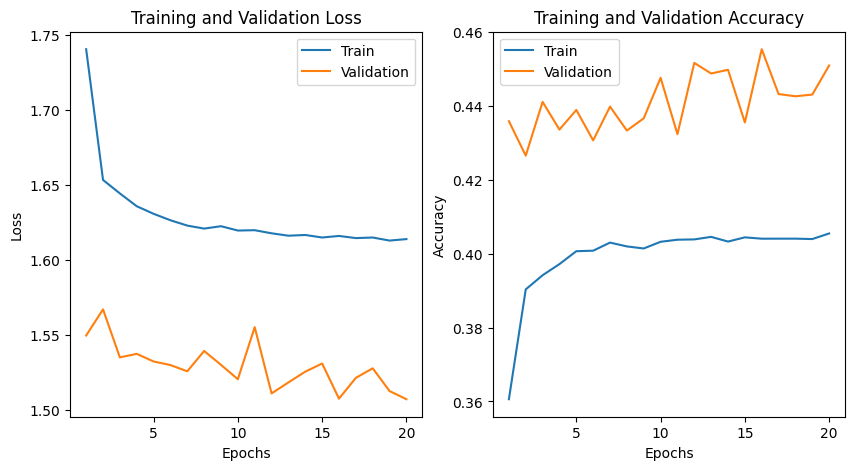

In [89]:
Model = MyMLP(layers = [24,64,32,12], dropout=0.2).to(device)
print(Model)
optimizer = optim.Adam(Model.parameters(), lr=0.01, weight_decay=0.001)
train_model(Model,torch.nn.CrossEntropyLoss(), optimizer,Noise_High_train_loader, Noise_High_test_loader,num_epochs=20)

Starting Epoch- 0
Epoch-0 model-0 Loss: 2.3802236558515815 Accuracy: 0.1666238158941269
Epoch-0 model-1 Loss: 2.3661983652959897 Accuracy: 0.15999308228492737
Epoch-0 model-2 Loss: 2.3806672268275975 Accuracy: 0.16296479105949402
Epoch-0 model-3 Loss: 2.407617868954622 Accuracy: 0.15320411324501038
Epoch-0 model-4 Loss: 2.385000766983515 Accuracy: 0.16116495430469513
Starting Epoch- 1
Epoch-1 model-0 Loss: 2.1531412418884566 Accuracy: 0.23938390612602234
Epoch-1 model-1 Loss: 2.159645262700093 Accuracy: 0.23170985281467438
Epoch-1 model-2 Loss: 2.1527991610237316 Accuracy: 0.23749011754989624
Epoch-1 model-3 Loss: 2.2264521298529227 Accuracy: 0.2173210084438324
Epoch-1 model-4 Loss: 2.1546174428885494 Accuracy: 0.23998714983463287
Starting Epoch- 2
Epoch-2 model-0 Loss: 2.013745548528961 Accuracy: 0.27486154437065125
Epoch-2 model-1 Loss: 2.06450372753264 Accuracy: 0.26049742102622986
Epoch-2 model-2 Loss: 2.0281034459796135 Accuracy: 0.2678896486759186
Epoch-2 model-3 Loss: 2.07782411

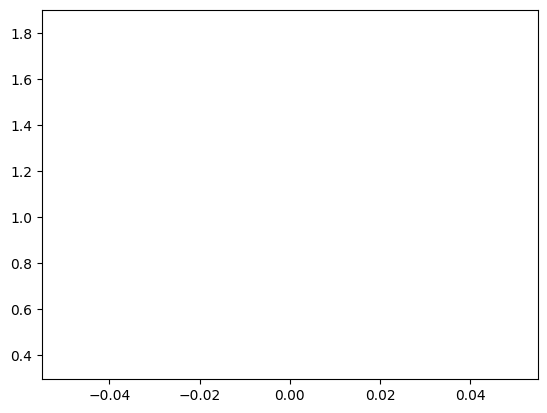

In [107]:
EnsembleModel = EnsembleClassifier(Noise_High_dataset, 5)
EnsembleModel.train(torch.nn.CrossEntropyLoss(), 128, 5)